# NLP - HW1
### April 2022
Authors: <br>
- Lior Tondovski
- Omer Yefet
- Ilan Vasilevsky


# Imports

In [1]:
# pip install glove-python-binary
# in order to create glove embbeding we had to install this package
# this package has many issues, including incompatibility with certain python versions

In [2]:
import gensim
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
from string import  ascii_lowercase
import nltk #TODO: figure out how to notify sagiv about new libraries
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time
from sklearn.metrics import roc_curve, auc
from glove import Corpus, Glove

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liort\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liort\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
data_path = 'projectData/'
models_path = 'models/'
tb_dir = 'tbs/'

# Load Data

In [4]:
raw_data = pd.read_csv(data_path+'dataset_raw.csv')

In [5]:
mini_raw_data = raw_data.sample(10000,random_state=42)

In [6]:
preprocessed_data =  mini_raw_data['review'].apply(gensim.utils.simple_preprocess)

In [7]:
stemmer= nltk.wordnet.WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
allowed_symbols = set(l for l in ascii_lowercase)

In [8]:
def preprocess_sentence(sentence):
    output_sentence = []
    for word in sentence:
        word = word.lower() #lower case the word
        if word not in stop_words:  #ignore stop words
            word = ''.join([i for i in word if i in allowed_symbols]) #remove characters which are not in allowed symbols
            word = stemmer.lemmatize(word)
            if len(word) >1 : #discard words with length<=1
                output_sentence.append(word)
    return output_sentence

In [9]:
preprocessed_data

12928    [it, nice, to, see, film, with, real, people, ...
35687    [welcome, to, movie, on, the, chilling, classi...
5211     [seriously, enjoy, dr, who, br, br, seriously,...
9523     [the, quintessential, let, get, ready, for, su...
7468     [this, is, one, of, my, favourite, comedy, fil...
                               ...                        
23843    [just, imagine, the, real, hitler, who, was, m...
14416    [this, movie, is, goofy, as, hell, think, it, ...
31919    [ve, long, heard, that, to, get, their, start,...
35883    [the, third, installment, of, the, carnosaur, ...
12799    [this, movie, is, now, appearing, on, digital,...
Name: review, Length: 10000, dtype: object

In [10]:
preprocessed_data = preprocessed_data.apply(preprocess_sentence, convert_dtype=True)

# Word2Vec Embedding

In [11]:
# we use embedding size of 50
model = gensim.models.Word2Vec(
    vector_size = 50,
    window = 5,
    min_count =5,
    workers= 4
)

model.build_vocab(preprocessed_data)
model.epochs = 30
model.train(preprocessed_data, total_examples=model.corpus_count, epochs = model.epochs)

(32455639, 36685830)

In [12]:
w2v_weights = torch.FloatTensor(model.wv.vectors)

# Glove Embedding

In [13]:
#GloVe training
corpus = Corpus()
corpus.fit(preprocessed_data, window=5)
glove = Glove(no_components=50)
glove.fit(corpus.matrix, epochs=30, no_threads=4)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

In [14]:
glove.word_vectors.shape

(45881, 50)

In [15]:
glove_weights = torch.FloatTensor(glove.word_vectors)

# Prepare the data by each of the embeddings

In [16]:
#Function the remove words that does not appear in the embedding vocabulary
# We use this because creation of embedding with word2vec ignores words with frequency lower than 5
def check_of_word_in_embedding_model(sentence, embedding_model):
    """
    Function that ignores word with low frequency, to avoid keyerrors
    returns sentences without words oov
    """
    output_sentence = []
    
    if embedding_model == model.wv:
        for word in sentence:
            try:
                dummy = embedding_model.get_index(word)
                output_sentence.append(word)
            except:
                continue
    #TODO: Debug except 
    elif embedding_model== glove:
        for word in sentence:
            try:
                dummy = embedding_model.dictionary[word]
                output_sentence.append(word)
            except:
                continue
    return output_sentence

In [17]:
#Data tokenizer
def tokenize(review, embedding_model):
    if embedding_model == model.wv:
        return torch.LongTensor([embedding_model.get_index(word) for word in review])
    else:
        return torch.LongTensor([embedding_model.dictionary[word] for word in review])

In [18]:
#Data based on word2vec embedding
preprocessed_data_w2v = preprocessed_data.apply(lambda x: check_of_word_in_embedding_model(x, model.wv))
X_w2v_full =preprocessed_data_w2v.apply(lambda x: tokenize(x, model.wv))
X_w2v = X_w2v_full.values

In [19]:
#Data based on GloVe embedding
preprocessed_data_glove = preprocessed_data.apply(lambda x: check_of_word_in_embedding_model(x, glove))
X_glove_full = preprocessed_data_glove.apply(lambda x: tokenize(x, glove))
X_glove = X_glove_full.values

In [20]:
y = torch.tensor(mini_raw_data['label'].values)

# Define Our Model

## Equations of the LSTM cell:

![lstm.png](lstmeq.jpeg)
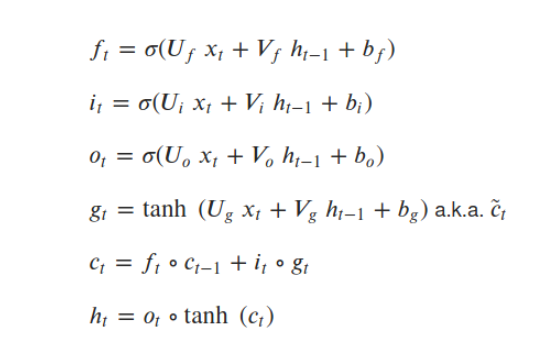

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int, label_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        self.label_size = label_sz

        self.U_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))

        self.U_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))

        self.U_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))

        self.U_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))

        self.hidden2label = nn.Parameter(torch.Tensor(hidden_sz, label_sz))
        
        self.init_weights()
    
    def init_weights(self):
            stdv = 1.0 / math.sqrt(self.hidden_size)
            for weight in self.parameters():
                weight.data.uniform_(-stdv, stdv)
                
    
    def forward(self, x, init_states=None):
            """
            assumes x.shape represents (batch_size, sequence_size, input_size)
            """
            seq_sz, embeded_sz = x.size()
            
            if init_states is None:
                h_t, c_t = (
                    torch.zeros(self.hidden_size).to(x.device),
                    torch.zeros(self.hidden_size).to(x.device),
                )
            else:
                h_t, c_t = init_states

            #loop over all words in sequence
            
            for t in range(seq_sz):
                x_t = x[t]
                i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
                f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
                g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
                o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
                c_t = f_t * c_t + i_t * g_t
                h_t = o_t * torch.tanh(c_t)
                    
                
                # last word:
                if t==seq_sz-1:
                    dropout = nn.Dropout(p=0.2)
                    out_ht = dropout(h_t)
                    y_pred = torch.sigmoid(out_ht @ self.hidden2label)
            
            return  y_pred

In [22]:
class Net(nn.Module):
    def __init__(self,input_sz: int, hidden_sz: int, label_sz: int, embedding_weights):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = LSTM(input_sz, hidden_sz, label_sz)
    
    def forward(self,x):
        x_embeded = self.embedding(x)
        pred = self.lstm(x_embeded)
        return pred

In [23]:
if torch.cuda.is_available():
    print(f'using: {torch.cuda.get_device_name(0)}')
else:
    print('using cpu')

using cpu


# Training Loop

In [24]:
def run_model_loop(X_input,y_input, data_size, test_p, classifier, epochs, criterion, optimizer,tb_dirname):
    
    X = X_input[:data_size]
    y = y_input[:data_size]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_p, random_state=42)
    
    train_loss_list = []
    test_loss_list = []
    train_auc_list=[]
    test_auc_list=[]

    writer = SummaryWriter(log_dir=f'{tb_dir}/{tb_dirname}_{time.time()}')
    j = 0

    for e in range(epochs):
        train_labels_list = []
        train_prediction_list = []
        test_labels_list = []
        test_prediction_list = []

        running_loss = 0
        classifier.train()

        for i, review in enumerate(X_train):
            j+=1
            label = y_train[i].view(1)
            review, label = review.to(device), label.to(device)
            optimizer.zero_grad()
            #use model to predict sentiment
            pred = classifier(review).to(torch.float)
            #to be safe 
            label = label.to(torch.float)
            loss = criterion(pred, label)
            #calculate loss
            running_loss+=loss.item()
            loss.backward()
            optimizer.step()
            train_prediction_list.append(pred.item())
            train_labels_list.append(label.item())
        
            writer.add_scalar(tag='loss/batch_loss_train', scalar_value=loss, global_step=j)

        epoch_train_loss = running_loss/len(X_train)
        train_loss_list.append(epoch_train_loss)
        fpr_t, tpr_t, thresholds_t = roc_curve(np.array(train_labels_list), np.array(train_prediction_list))
        train_auc = auc(fpr_t, tpr_t)
        train_auc_list.append(train_auc)
        
        test_loss = 0
        classifier.eval()
        # we dont need to update weights, so we define no_grad() to save memory
        with torch.no_grad():
            for i, review in enumerate(X_test):
                label= y_test[i].view(1)
                review, label = review.to(device), label.to(device)
                test_pred = classifier(review).to(torch.float)
                label = label.to(torch.float)
                loss=criterion(test_pred, label)
                test_loss+=loss.item()
                test_prediction_list.append(test_pred.item())
                test_labels_list.append(label.item())
        
        epoch_test_loss = test_loss/len(X_test)
        test_loss_list.append(epoch_test_loss)
        fpr_v, tpr_v, thresholds_v = roc_curve(np.array(test_labels_list),np.array(test_prediction_list))
        test_auc = auc(fpr_v, tpr_v)
        test_auc_list.append(test_auc)
        
        #Tensorboard documentation
        #loss
        writer.add_scalar(tag='loss/train', scalar_value=epoch_train_loss, global_step=e)
        writer.add_scalar(tag='loss/test', scalar_value=epoch_test_loss, global_step=e)
        #auc
        writer.add_scalar(tag='auc/train', scalar_value=train_auc, global_step=e)
        writer.add_scalar(tag='auc/test', scalar_value=test_auc, global_step=e)

    return {'train_loss':train_loss_list,
            'train_auc':train_auc_list,
            'test_auc':test_auc_list,
            'test_loss':test_loss_list,
            'fpr_v':fpr_v,
            'tpr_v':tpr_v
            }

# Model Comparison

In [25]:
embeddings = ['w2v_weight','glove_weight']
learning_rates = [0.01,0.001]
hidden_sizes = [5,15]

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
criterion = nn.BCELoss()
epochs = 10

In [27]:
models  = [[i,j,k] for i in embeddings for j in learning_rates for k in hidden_sizes]

In [28]:
def run_all_models(models):
    train_auc_per_model = []
    test_auc_per_model = []
    train_loss_per_model = []
    test_loss_per_model = []

    for i, model in enumerate(models):
        if model[0] == 'w2v_weight':
            LSTM_model = Net(50, model[2], 1, w2v_weights).to(device)
            optimizer = optim.Adam(LSTM_model.parameters(), lr = model[1], weight_decay = 1e-3)
            model_run = run_model_loop(X_w2v,y,2000,0.25,LSTM_model,epochs,criterion,optimizer,'model_testing')

        else:
            LSTM_model = Net(50, model[2], 1, glove_weights).to(device)
            optimizer = optim.Adam(LSTM_model.parameters(), lr = model[1], weight_decay = 1e-3)
            model_run = run_model_loop(X_glove,y,2000,0.25,LSTM_model,epochs,criterion,optimizer,'model_testing')

        train_auc_per_model.append(model_run['train_auc'])
        test_auc_per_model.append(model_run['test_auc'])
        train_loss_per_model.append(model_run['train_loss'])
        test_loss_per_model.append(model_run['test_loss'])

        torch.save(LSTM_model.state_dict(), models_path+'Model_'+str(i+1))
    return train_auc_per_model, test_auc_per_model , train_loss_per_model , test_loss_per_model

train_auc_per_model, test_auc_per_model , train_loss_per_model , test_loss_per_model = run_all_models(models)

In [29]:
models

[['w2v_weight', 0.01, 5],
 ['w2v_weight', 0.01, 15],
 ['w2v_weight', 0.001, 5],
 ['w2v_weight', 0.001, 15],
 ['glove_weight', 0.01, 5],
 ['glove_weight', 0.01, 15],
 ['glove_weight', 0.001, 5],
 ['glove_weight', 0.001, 15]]

## Loss and Auc Plots - Performance Analysis

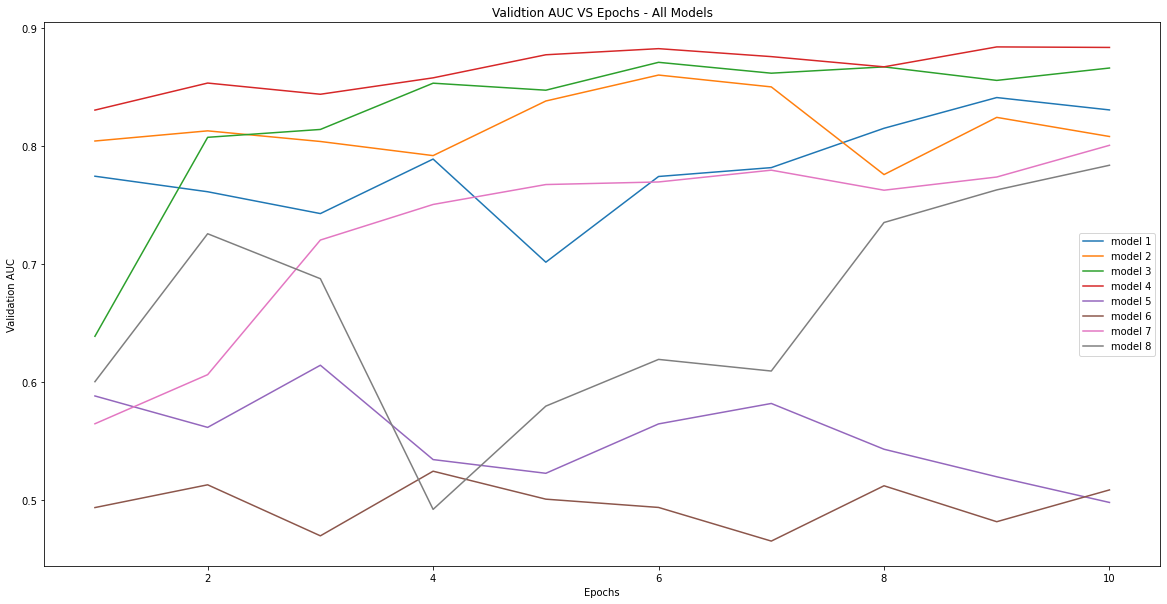

In [30]:
# create data
x = range(1, epochs+1)
plt.figure(figsize=(20,10))
for i, auc in enumerate (test_auc_per_model):
    # plot lines
    plt.plot(x, auc, label ='model ' + str(i+1))
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Validation AUC")
plt.title("Validtion AUC VS Epochs - All Models")
plt.show()

In [31]:
print(f'The configuration with the highest AUC score is model 4')
print(f'Configuration parameters are: {models[3]}')
print(f'The maximal test AUC score is {round(max(test_auc_per_model[3]),2)}')
print('')
print(f'The configuration with the lower AUC score is model 6')
print(f'Configuration parameters are: {models[5]}')
print(f'The worse test AUC score is {round(st.mean(test_auc_per_model[5]),2)}')


The configuration with the highest AUC score is model 4
Configuration parameters are: ['w2v_weight', 0.001, 15]
The maximal test AUC score is 0.88

The configuration with the lower AUC score is model 6
Configuration parameters are: ['glove_weight', 0.01, 15]
The worse test AUC score is 0.5


## Deeper Analysis 
Deeper analysis of differnce between models who used w2v and models who used glove embedding.

In [32]:
def calc_average_auc_by_embedding_method(models):
    w2v_models_aucs = []
    glove_models_aucs = []
    w2v_models = models[:4]
    glove_models = models[4:]
    for i in range(len(w2v_models)):
        w2v_models_aucs.extend(test_auc_per_model[i])
    for i in range(len(glove_models)):
        glove_models_aucs.extend(test_auc_per_model[i+3])
    return w2v_models_aucs, glove_models_aucs

w2v_models_aucs, glove_models_aucs  = calc_average_auc_by_embedding_method(models)



In [33]:
embedding_method = []
for i in range(80):
    if i<=39:
        embedding_method.append('w2v')
    else:
        embedding_method.append('GloVe')


In [34]:
models_auc = []
models_auc.extend(w2v_models_aucs)
models_auc.extend(glove_models_aucs)
models_aucs_by_embedding_dic = {'models_aucs': models_auc, 'embedding_method': embedding_method}
models_aucs_by_embedding_df = pd.DataFrame(models_aucs_by_embedding_dic)

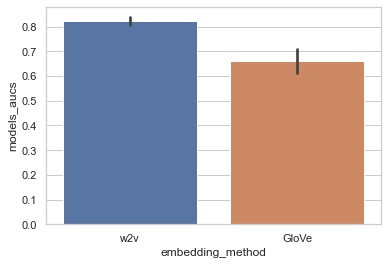

In [35]:
#Barchart - difference in the average AUC between models who used w2v embedding and model who used glove embedding
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="embedding_method", y="models_aucs", data=models_aucs_by_embedding_df)

In [36]:
#Statistical test for comparing means
stats.ttest_ind(w2v_models_aucs, glove_models_aucs)

Ttest_indResult(statistic=6.29063279807088, pvalue=1.70083700993269e-08)

In [37]:
#Differnce between models who use w2v embedding vs glove embeddings analysis
print(f'It is easy to notice that the conigurations with the low AUC are those who uses glove weights.')
print(f'The difference is statistically significant')
print(f'We assume that if we would have taken more data to training the model we wouldnt have seen such a big differnce in the performance due to the embedding method chosen')

It is easy to notice that the conigurations with the low AUC are those who uses glove weights.
The difference is statistically significant
We assume that if we would have taken more data to training the model we wouldnt have seen such a big differnce in the performance due to the embedding method chosen


Loss vs Epochs Analysis for The Chosen Model

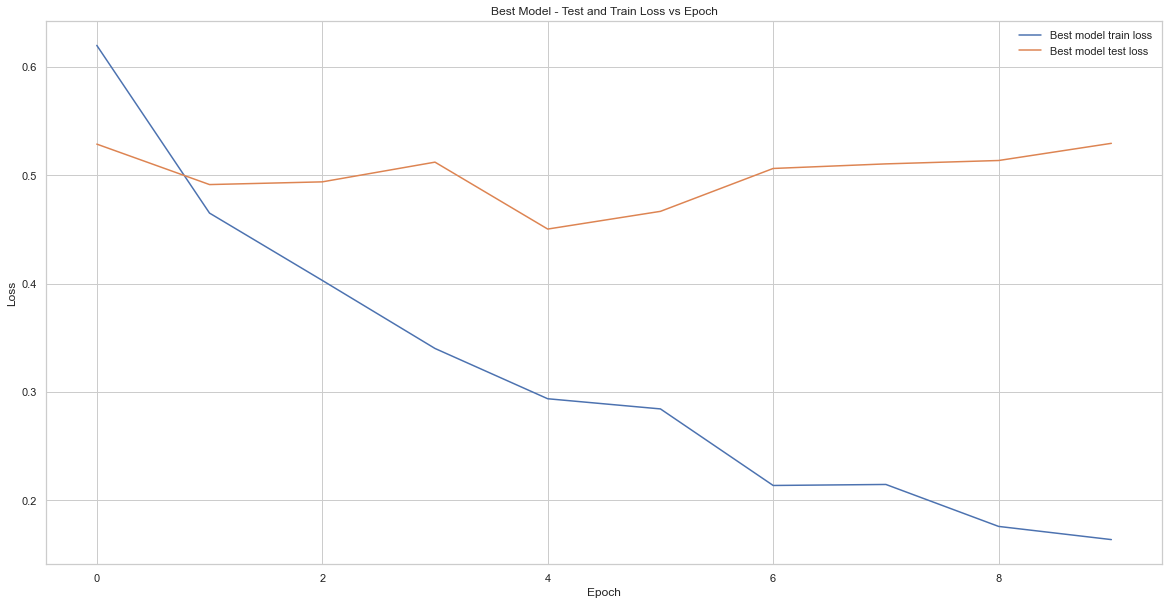

In [38]:
#Loss vs epochs graph 
plt.figure(figsize=(20,10))
plt.title("Best Model - Test and Train Loss vs Epoch")
plt.plot(train_loss_per_model[3], label = 'Best model train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(test_loss_per_model[3], label = 'Best model test loss')
plt.legend(frameon = False)

Analysis of the loss graph:

There is a change in trend of the test loss after epoch number 4.
It might be because we have taken a small part of the data and our model is heavy with parameters as a result, it might be overfitting.
To cope with it, we chose large weight decay parameters to reduce the model's complexity and prevent overfitting